## Coding Discussion 6
### Abigail Paterson
#### arp140

In [1]:
#import packages
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#data pre processing
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

In [5]:
#load data
train = pd.read_csv("../train_data.csv")
test = pd.read_csv("../test_data.csv")

train.head()

,OBJECTID,SSL,BATHRM,HF_BATHRM,HEAT,HEAT_D,AC,NUM_UNITS,ROOMS,BEDRM,...,ROOF,ROOF_D,INTWALL,INTWALL_D,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,LN_PRICE
0,89279,5260 0823,2.0,1.0,1.0,Forced Air,Y,1.0,6.0,3.0,...,1.0,Comp Shingle,11.0,Hardwood/Carp,1.0,0.0,11,688,2018-07-22T18:01:43.000Z,12.409013
1,40572,2605 0056,3.0,0.0,13.0,Hot Water Rad,N,2.0,9.0,4.0,...,2.0,Built Up,6.0,Hardwood,2.0,1.0,24,2064,2018-07-22T18:01:43.000Z,13.513053
2,32817,1956 0116,4.0,1.0,7.0,Warm Cool,Y,1.0,10.0,5.0,...,2.0,Built Up,11.0,Hardwood/Carp,1.0,2.0,12,4583,2018-07-22T18:01:43.000Z,14.417091
3,12939,0939 0056,3.0,1.0,1.0,Forced Air,Y,1.0,10.0,4.0,...,13.0,Neopren,6.0,Hardwood,1.0,2.0,11,2147,2018-07-22T18:01:43.000Z,13.547631
4,59018,3200 0254,2.0,0.0,13.0,Hot Water Rad,N,1.0,6.0,3.0,...,2.0,Built Up,6.0,Hardwood,1.0,0.0,13,1576,2018-07-22T18:01:43.000Z,13.023647


In [6]:
test.head()

,OBJECTID,SSL,BATHRM,HF_BATHRM,HEAT,HEAT_D,AC,NUM_UNITS,ROOMS,BEDRM,...,ROOF,ROOF_D,INTWALL,INTWALL_D,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,LN_PRICE
0,89279,5260 0823,2.0,1.0,1.0,Forced Air,Y,1.0,6.0,3.0,...,1.0,Comp Shingle,11.0,Hardwood/Carp,1.0,0.0,11,688,2018-07-22T18:01:43.000Z,12.409013
1,40572,2605 0056,3.0,0.0,13.0,Hot Water Rad,N,2.0,9.0,4.0,...,2.0,Built Up,6.0,Hardwood,2.0,1.0,24,2064,2018-07-22T18:01:43.000Z,13.513053
2,32817,1956 0116,4.0,1.0,7.0,Warm Cool,Y,1.0,10.0,5.0,...,2.0,Built Up,11.0,Hardwood/Carp,1.0,2.0,12,4583,2018-07-22T18:01:43.000Z,14.417091
3,12939,0939 0056,3.0,1.0,1.0,Forced Air,Y,1.0,10.0,4.0,...,13.0,Neopren,6.0,Hardwood,1.0,2.0,11,2147,2018-07-22T18:01:43.000Z,13.547631
4,59018,3200 0254,2.0,0.0,13.0,Hot Water Rad,N,1.0,6.0,3.0,...,2.0,Built Up,6.0,Hardwood,1.0,0.0,13,1576,2018-07-22T18:01:43.000Z,13.023647


Our objective is to attempt to predict the log selling price of a house in DC based on the features BATHRM(number of bathrooms), BEDRM(number of bedrooms), GBA and LANDAREA(total land area)

### Data Exploration

<AxesSubplot:>

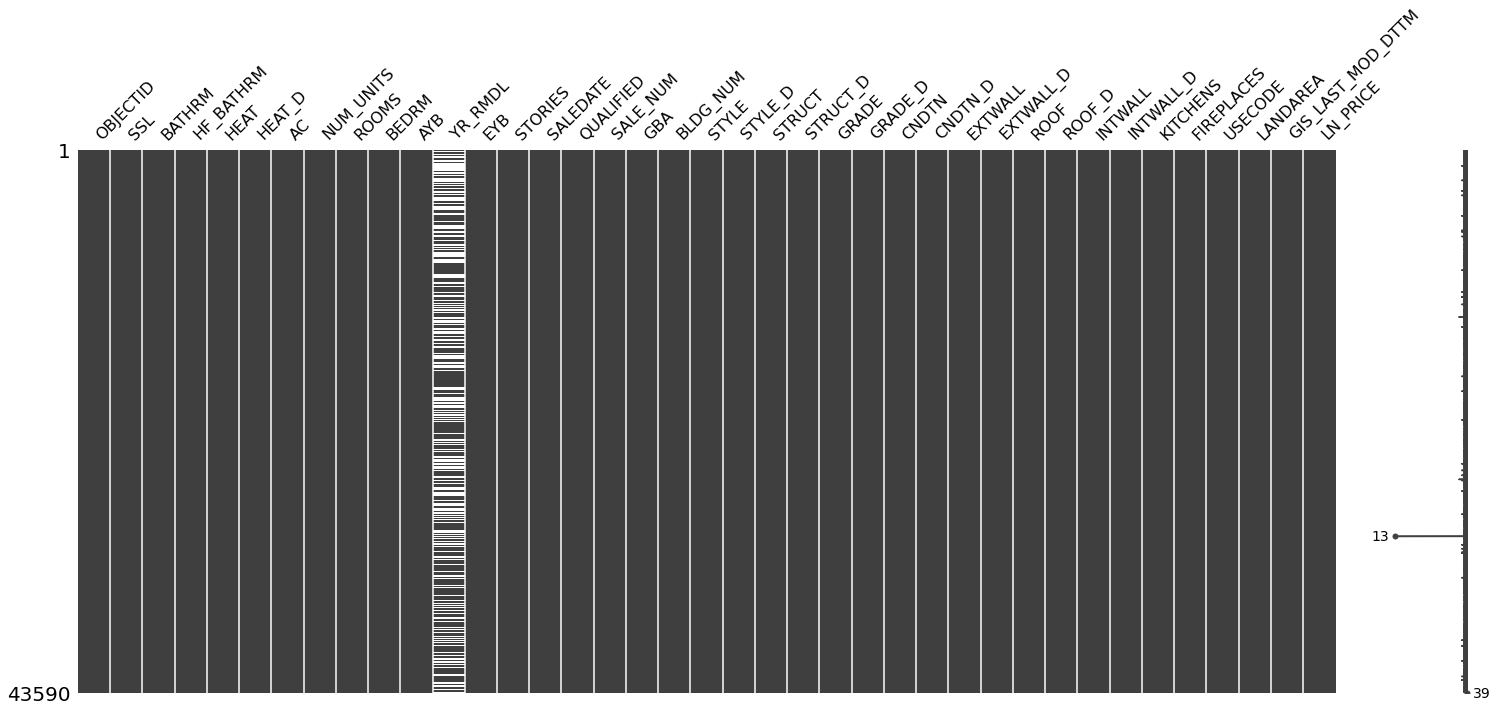

In [7]:
#first look for missing data 
miss.matrix(train)

I notice there is are a lot of missing values in YR_RMDL. I will drop the rows with missing data 

In [50]:
train = train.dropna()
test = test.dropna()

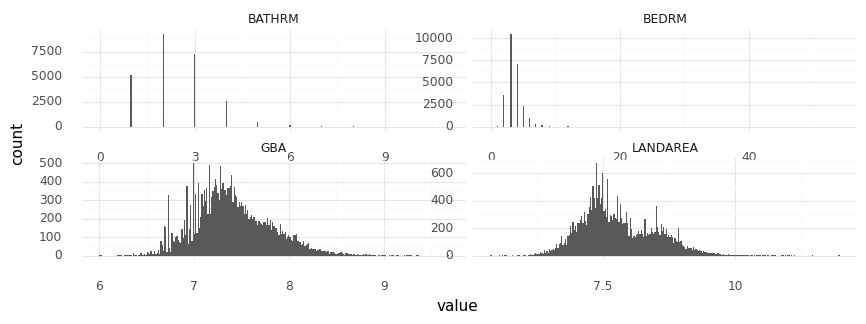

<ggplot: (169218245690)>

In [51]:
#seaparate data
y_train = train[["LN_PRICE"]]
X_train = train[['BATHRM', 'BEDRM', 'GBA', 'LANDAREA']]

y_test = test['LN_PRICE']
X_test = test[['BATHRM', 'BEDRM', 'GBA', 'LANDAREA']]

#make GBA and land area logrithmic
X_train["GBA"] = np.log(X_train["GBA"])
X_train["LANDAREA"] = np.log(X_train["LANDAREA"])

X_test["GBA"] = np.log(X_test["GBA"])
X_test["LANDAREA"] = np.log(X_test["LANDAREA"])
#view each features distribution
(
    ggplot(X_train.melt(),aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable",scales="free") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
)

This shows that we will need to do scaling later on.

### Modeling Pipeline

In [18]:
#set folds index for comparable samples
fold_generator = KFold(n_splits=5, shuffle=True, random_state=111)

#specify preprocessing steps
preprocess = ColumnTransformer(transformers=[("num", pp.MinMaxScaler(),
                            ['BATHRM','BEDRM', 'GBA', 'LANDAREA'])])

#create model pipe
pipe = Pipeline(steps=[('pre_process', preprocess), ('model',None)])


In [19]:
#specify the models and their parameters
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]


In [20]:
#set up grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)


In [21]:
#fit the model 
search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['BATHRM',
                                                                          'BEDRM',
                                                                          'GBA',
                                                                          'LANDAREA'])])),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsRegressor(n_neighbors=30)],
                          'model__n_neighbors': [10, 15, 20, 25, 30]},
                         {'model': [DecisionTreeRegressor()],
                        

In [22]:
#the mean of sample error
search.best_score_

-0.41977230763399137

In [23]:
#search for best parameters
search.best_params_

{'model': KNeighborsRegressor(n_neighbors=30), 'model__n_neighbors': 30}

### Test Performance

In [30]:
#Predict new values from test data
y_pred = search.predict(X_test)
m.mean_squared_error(y_test, y_pred)

0.3982886586757687

In [31]:
# R squared
m.r2_score(y_test, y_pred)

0.34276347631834214

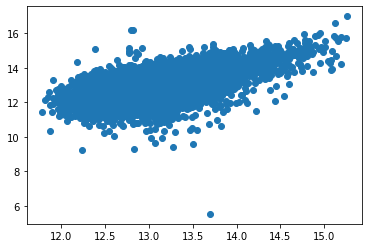

In [41]:
plt.scatter(y_pred, y_test)
plt

In [55]:
#plot line of best fit
#(
#    ggplot(pd.DataFrame(dict(pred=y_pred,truth=y_test)),
#          aes(x='pred',y="truth")) +
#    geom_point(alpha=.25) +
#    geom_abline(linetype="dashed",color="darkred",size=1) +
#    theme_bw() +
#    theme(figure_size=(10,7))
#)
#gave me an "error must be 1-Dimensional" error which I do not understand